In [39]:
from ocpmodels.models.rhescnv8clean.tests.utils import test_context

rhctx = test_context("/workspaces/ocp/configs/s2ef/2M/escn/rhescn.yml").__enter__()
escnctx = test_context(
    "/workspaces/ocp/configs/s2ef/2M/escn/eSCN-L6-M2-Lay12.yml"
).__enter__()

2024-04-04 17:53:21 (WARNING): Detected old config, converting to new format. Consider updating to avoid potential incompatibilities.


2024-04-04 17:53:21 (INFO): amp: true
cmd:
  checkpoint_dir: ./checkpoints/2024-04-04-17-53-04
  commit: efbcfe2
  identifier: ''
  logs_dir: ./logs/wandb/2024-04-04-17-53-04
  print_every: 10
  results_dir: ./results/2024-04-04-17-53-04
  seed: 0
  timestamp_id: 2024-04-04-17-53-04
dataset:
  format: trajectory_lmdb
  grad_target_mean: 0.0
  grad_target_std: 2.887317180633545
  key_mapping:
    force: forces
    y: energy
  normalize_labels: true
  src: /mnt/datasets/s2ef/2M/train/
  target_mean: -0.7554450631141663
  target_std: 2.887317180633545
  transforms:
    normalizer:
      energy:
        mean: -0.7554450631141663
        stdev: 2.887317180633545
      forces:
        mean: 0.0
        stdev: 2.887317180633545
eval_metrics:
  metrics:
    energy:
    - mae
    forces:
    - forcesx_mae
    - forcesy_mae
    - forcesz_mae
    - mae
    - cosine_similarity
    - magnitude_error
    misc:
    - energy_forces_within_threshold
gpus: 1
logger: wandb
loss_fns:
- energy:
    coeffic

2024-04-04 17:53:21 (INFO): Batch balancing is disabled for single GPU training.
2024-04-04 17:53:21 (INFO): Batch balancing is disabled for single GPU training.
2024-04-04 17:53:21 (INFO): Loading model: rhescnv8clean
2024-04-04 17:53:21 (INFO): Loaded RHESCN with 8428544 parameters.


2024-04-04 17:53:21 (WARNING): Detected old config, converting to new format. Consider updating to avoid potential incompatibilities.


2024-04-04 17:53:21 (INFO): amp: true
cmd:
  checkpoint_dir: ./checkpoints/2024-04-04-17-53-04
  commit: efbcfe2
  identifier: ''
  logs_dir: ./logs/wandb/2024-04-04-17-53-04
  print_every: 10
  results_dir: ./results/2024-04-04-17-53-04
  seed: 0
  timestamp_id: 2024-04-04-17-53-04
dataset:
  format: trajectory_lmdb
  grad_target_mean: 0.0
  grad_target_std: 2.887317180633545
  key_mapping:
    force: forces
    y: energy
  normalize_labels: true
  src: /mnt/datasets/s2ef/2M/train/
  target_mean: -0.7554450631141663
  target_std: 2.887317180633545
  transforms:
    normalizer:
      energy:
        mean: -0.7554450631141663
        stdev: 2.887317180633545
      forces:
        mean: 0.0
        stdev: 2.887317180633545
eval_metrics:
  metrics:
    energy:
    - mae
    forces:
    - forcesx_mae
    - forcesy_mae
    - forcesz_mae
    - mae
    - cosine_similarity
    - magnitude_error
    misc:
    - energy_forces_within_threshold
gpus: 1
logger: wandb
loss_fns:
- energy:
    coeffic

In [40]:
import lovely_tensors as lt

lt.monkey_patch()

In [41]:
rhescn = rhctx.trainer._unwrapped_model
escn = escnctx.trainer._unwrapped_model
dl = rhctx.trainer.train_loader
print(type(rhescn), type(escn), type(dl))

<class 'ocpmodels.models.rhescnv8clean.model.RHESCN'> <class 'ocpmodels.models.escn.escn.eSCN'> <class 'torch.utils.data.dataloader.DataLoader'>


In [42]:
batch = next(iter(dl)).cuda()
print(batch)

DataBatch(pos=[51, 3], cell=[1, 3, 3], atomic_numbers=[51], natoms=[1], tags=[51], fixed=[51], sid=[1], fid=[1], id=[1], energy=[1], forces=[51, 3], batch=[51], ptr=[2])


In [43]:
import rich

from ocpmodels.models.rhescnv8clean.radius_graph_utils import (
    generate_graph,
)

(
    edge_index,
    edge_distance,
    edge_distance_vec,
    _,
    _,  # cell offset distances
    _,
) = generate_graph(
    batch.pos,
    batch.cell,
    batch.batch,
    batch.natoms,
    cutoff=rhescn.cutoff,
    max_neighbors=rhescn.max_neighbors,
    use_pbc=rhescn.use_pbc,
    otf_graph=rhescn.otf_graph,
    padded_collater_config=rhctx.trainer._padded_collater_config,
)
pos = batch.pos
atomic_numbers = batch.atomic_numbers.long()
batch_idx = batch.batch
natoms = batch.natoms
fixed = batch.fixed
energy_target = batch.energy
force_target = batch.forces

rich.print(
    {
        "pos": pos,
        "atomic_numbers": atomic_numbers,
        "batch_idx": batch_idx,
        "natoms": natoms,
        "fixed": fixed,
        "energy_target": energy_target,
        "force_target": force_target,
        "edge_index": edge_index,
        "edge_distance": edge_distance,
        "edge_distance_vec": edge_distance_vec,
    }
)

{
    'pos': tensor[51, 3] n=153 x∈[-0.010, 32.595] μ=10.041 σ=9.819 cuda:0,
    'atomic_numbers': tensor[51] i64 x∈[1, 80] μ=40.000 σ=33.058 cuda:0,
    'batch_idx': tensor[51] i64 all_zeros cuda:0,
    'natoms': tensor[1] i64 cuda:0 [51],
    'fixed': tensor[51] x∈[0., 1.000] μ=0.588 σ=0.497 cuda:0,
    'energy_target': tensor[1] f64 cuda:0 [-2.016],
    'force_target': tensor[51, 3] n=153 x∈[-0.286, 0.253] μ=1.461e-10 σ=0.068 cuda:0,
    'edge_index': tensor[2, 1218] i64 n=2436 (19Kb) x∈[0, 50] μ=24.060 σ=14.260 cuda:0,
    'edge_distance': tensor[1218] 4.8Kb x∈[1.092, 8.069] μ=4.571 σ=1.319 cuda:0,
    'edge_distance_vec': tensor[1218, 3] n=3654 (14Kb) x∈[-7.391, 7.197] μ=0.000 σ=2.747 cuda:0
}

In [44]:
from ocpmodels.models.rhescnv8clean.wigner_efficient import rot_from_xyz

wigner_precomp = rot_from_xyz(
    edge_distance_vec,
    rhescn.rh_grid.from_grid_sh_tri,
    rhescn.jdp,
    rhescn.mmax_list[0],
    rhescn.rh_idx,
    rhescn.rh_mask,
    device=edge_distance_vec.device,
    dtype=edge_distance_vec.dtype,
    keep_full_wigner=True,
    keep_rot_mat=True,
    rotmat_seed=0,
    use_rotmat=True,
    # vectorize=False,
)
rich.print(wigner_precomp)

Rhomboidal_SO3_Rotation_Parallel_FastMM(
    wigner=tensor[2436, 50, 81] n=9865800 (38Mb) x∈[-1.000, 1.000] μ=0.000 σ=0.105 cuda:0,
    wigner_inv_from_grid=tensor[1218, 81, 342] n=33741036 (0.1Gb) x∈[-0.062, 0.067] μ=0.000 σ=0.012 cuda:0,
    full_wigner=tensor[1218, 81, 81] n=7991298 (30Mb) x∈[-1.000, 1.000] μ=0.000 σ=0.111 cuda:0,
    rotmat=tensor[1218, 3, 3] n=10962 (43Kb) x∈[-1.000, 1.000] μ=-0.050 σ=0.575 cuda:0
)

In [45]:
import torch

from ocpmodels.models.escn.so3 import SO3_Rotation
from ocpmodels.models.rhescnv8clean.wigner_efficient import rot_from_xyz

wigner_precomp = rot_from_xyz(
    edge_distance_vec,
    rhescn.rh_grid.from_grid_sh_tri,
    rhescn.jdp,
    rhescn.mmax_list[0],
    rhescn.rh_idx,
    rhescn.rh_mask,
    device=edge_distance_vec.device,
    dtype=edge_distance_vec.dtype,
    keep_full_wigner=True,
    keep_rot_mat=True,
    rotmat_seed=0,
    use_rotmat=True,
    # vectorize=False,
)
rich.print(wigner_precomp)

edge_rot_mat = escn._init_edge_rot_mat(
    batch,
    edge_index,
    edge_distance_vec,
    seed=0,
)
rich.print(edge_rot_mat)

if wigner_precomp.rotmat is not None:
    torch.testing.assert_close(wigner_precomp.rotmat, edge_rot_mat)


SO3_edge_rot = SO3_Rotation(edge_rot_mat, escn.lmax_list[0])
print(SO3_edge_rot)

torch.testing.assert_close(
    SO3_edge_rot.wigner,
    wigner_precomp.full_wigner,
)

Rhomboidal_SO3_Rotation_Parallel_FastMM(
    wigner=tensor[2436, 50, 81] n=9865800 (38Mb) x∈[-1.000, 1.000] μ=0.000 σ=0.105 cuda:0,
    wigner_inv_from_grid=tensor[1218, 81, 342] n=33741036 (0.1Gb) x∈[-0.062, 0.067] μ=0.000 σ=0.012 cuda:0,
    full_wigner=tensor[1218, 81, 81] n=7991298 (30Mb) x∈[-1.000, 1.000] μ=0.000 σ=0.111 cuda:0,
    rotmat=tensor[1218, 3, 3] n=10962 (43Kb) x∈[-1.000, 1.000] μ=-0.050 σ=0.575 cuda:0
)

tensor[1218, 3, 3] n=10962 (43Kb) x∈[-1.000, 1.000] μ=-0.050 σ=0.575 cuda:0

SO3_Rotation()


In [56]:
escn_grid = escn.SO3_grid[-1][-1]
escn_grid._initialize(batch.pos.device)

rhescn_to_grid_mat = rhescn.rh_grid.to_grid_sh_tri
escn_to_grid_mat = escn_grid.to_grid_mat.view(-1, escn_grid.to_grid_mat.shape[-1])
rich.print(
    {
        "rhescn_to_grid_mat": rhescn_to_grid_mat,
        "escn_to_grid_mat": escn_to_grid_mat,
    }
)
torch.testing.assert_close(
    rhescn.rh_grid.to_grid_sh_tri,
    escn_grid.to_grid_mat.view(-1, escn_grid.to_grid_mat.shape[-1]),
)

rhescn_from_grid_mat = rhescn.rh_grid.from_grid_sh_tri
escn_from_grid_mat = escn_grid.from_grid_mat.reshape(
    -1, escn_grid.from_grid_mat.shape[-1]
).T
rich.print(
    {
        "rhescn_from_grid_mat": rhescn_from_grid_mat,
        "escn_from_grid_mat": escn_from_grid_mat,
    }
)
torch.testing.assert_close(rhescn_from_grid_mat, escn_from_grid_mat)

{
    'rhescn_to_grid_mat': tensor[342, 81] n=27702 (0.1Mb) x∈[-0.979, 1.009] μ=0.009 σ=0.282 cuda:0,
    'escn_to_grid_mat': tensor[342, 81] n=27702 (0.1Mb) x∈[-0.979, 1.009] μ=0.009 σ=0.282 cuda:0
}

{
    'rhescn_from_grid_mat': tensor[81, 342] n=27702 (0.1Mb) x∈[-0.041, 0.041] μ=0.000 σ=0.012 cuda:0,
    'escn_from_grid_mat': tensor[81, 342] n=27702 (0.1Mb) x∈[-0.041, 0.041] μ=0.000 σ=0.012 cuda:0
}

In [92]:
from e3nn.o3 import ToS2Grid

device = escn_grid.to_grid_mat.device
to_grid = ToS2Grid(
    escn_grid.lmax,
    (escn_grid.lat_resolution, escn_grid.long_resolution),
    normalization="integral",
    device=device,
)
to_grid_mat = torch.einsum("mbi,am->bai", to_grid.shb, to_grid.sha).detach()
to_grid_mat[:, :, 0]

tensor[18, 19] n=342 (1.3Kb) x∈[0.282, 0.282] μ=0.282 σ=0. cuda:0

In [103]:
from e3nn.o3 import FromS2Grid

device = escn_grid.from_grid_mat.device
from_grid = FromS2Grid(
    (escn_grid.lat_resolution, escn_grid.long_resolution),
    0,
    normalization="integral",
    device=device,
)
from_grid_mat = torch.einsum("am,mbi->bai", from_grid.sha, from_grid.shb).detach()
from_grid_mat

tensor[18, 19, 1] n=342 (1.3Kb) x∈[0.001, 0.016] μ=0.010 σ=0.005 cuda:0

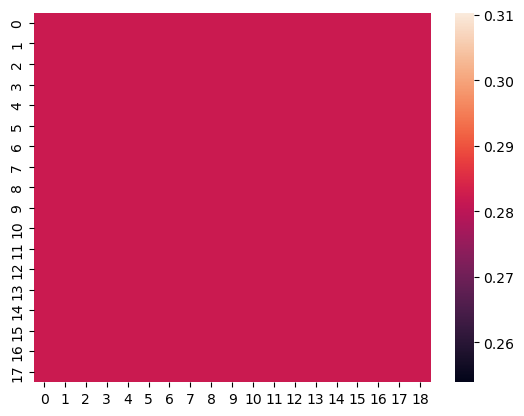

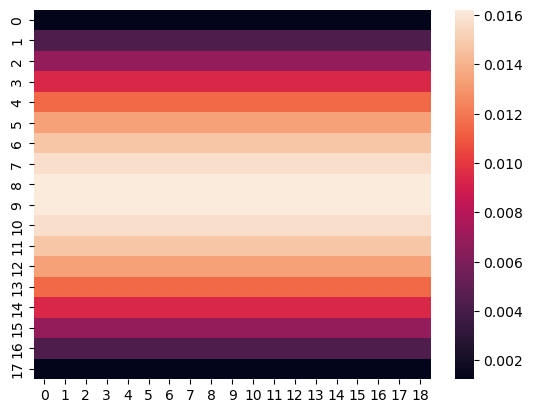

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(to_grid_mat[:, :, 0].cpu().numpy())
plt.show()

sns.heatmap(from_grid_mat[:, :, 0].cpu().numpy())
plt.show()